In [137]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as plt
import matplotlib.patches as patches
import matplotlib.text as text
import numpy as np
import pandas as pd
from sklearn.linear_model import TheilSenRegressor
import ultraplot as uplt

## Subplot 1: Theoretical Trends

In [4]:
x = np.linspace(0, 364, 365)

# Parameters for modified double logistic model
a = 0.2 # Minimum EVI
b = 0.8 # Range of EVI
c = 0.0007 # Slope of greendown trend
m_1 = -0.4 # Slope of first logistic
m_2 = -0.07 # Slope of second logistic
n_1 = 150 # Start of Season
n_2 = 290 # End of Season

normal_veg = a + (b - c*x) * ( 1/(1+np.exp(m_1*(x - n_1))) - 1/(1+np.exp(m_2*(x - n_2))) )


x_test = np.arange(150, 250)
y = a + (b - c*x_test) * ( 1/(1+np.exp(m_1*(x_test - n_1))) - 1/(1+np.exp(m_2*(x_test - n_2))) )

slope, intercept = np.polyfit(x_test, y, 1)
y_ols = slope*x + intercept

# Parameters of severe defoliation
b_d = 0.1 # Decrease in maximum EVI
d = 0.4 # Strength of defol
m_3 = 0.004 # Rate of defoliation
n_3 = 180 # ~ Date of Peak Defoliation

severe_defol = a + (b - b_d - c*x) * ( 1/(1+np.exp(m_1*(x - n_1))) - 1/(1+np.exp(m_2*(x - n_2))) ) - d*np.exp(-m_3*(x - n_3)**2)

In [5]:
x_test = np.arange(150, 250)
y = a + (b - c*x_test) * ( 1/(1+np.exp(m_1*(x_test - n_1))) - 1/(1+np.exp(m_2*(x_test - n_2))) )

theil = TheilSenRegressor()
theil.fit(x_test.reshape(-1, 1), y)

y_theil = theil.predict(x.reshape(-1, 1))

In [140]:
def plot_defoliation_theory(ax, lw):
    ax.plot(x, normal_veg, linewidth=lw, label='Normal', color='shamrock green')
    ax.plot(x, severe_defol, linewidth=lw, label='Severe Defol', color='blue')

    # SOS/EOS
    # rect = patches.Rectangle((150, 0), 140, 1, facecolor='lightgray', label='Growing Season')
    # ax.add_patch(rect)

    # Defoliation Period
    rect = patches.Rectangle((160, 0), 40, 1, facecolor='gray6', label='Defol. Period')
    ax.add_patch(rect)

    ax.format(ylim=[0,1], ylabel='EVI', ylocator=[0, 1],
              xlim=[0, 365], xlocator=[0, 180, 360])

    t1 = text.Text(x=0.4, y=0.8, text="Normal", color='shamrock green', fontsize=12, weight='bold', ha='center')
    t2 = text.Text(x=0.4, y=0.3, text="Defoliated", color='blue', fontsize=12, weight='bold', ha='center')
    ax.add_artist(t1)
    ax.add_artist(t2)

## Subplot 2: Defoliation Estimates across New York State

In [112]:
def process_forest_tiles(filename):
    df = gpd.read_file(filename)
    df['defol_forest_2'] = df['defoliation_2']/df['forest']
    df['defol_forest_mask_2'] = df['defoliation_2']/df['qa_mask_2']
    df['defol_forest_3'] = df['defoliation_3']/df['forest']
    df['defol_forest_mask_3'] = df['defoliation_3']/df['qa_mask_3']
    return df

forest_2021 = process_forest_tiles('./Data/TimeImpacts/forest_grid_2021.geojson')

min_prop = 3/4
forest_2021['suf_obs'] = forest_2021['qa_mask_3']/forest_2021['forest'] >= min_prop

In [113]:
def plot_map(ax, fig):
    norm = plt.colors.Normalize(vmin=0, vmax=0.6)
    cmap = uplt.Colormap('Reds3')

    for row in forest_2021.itertuples():
        if row.suf_obs:
            region = cfeature.ShapelyFeature(
                row.geometry,
                ccrs.epsg(5070),
                facecolor=cmap(norm(row.defol_forest_3)),
                edgecolor=cmap(norm(row.defol_forest_3)))
        else:
            region = cfeature.ShapelyFeature(
                row.geometry,
                ccrs.epsg(5070),
                facecolor='gray4',
                edgecolor='gray4')
        ax.add_feature(region)
    ax.set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES)
    ax.format(grid=False, facecolor='white', title=str(2021))

    fig.colorbar(cmap, vmin=norm.vmin, vmax=norm.vmax, 
                 loc='b', cols=[2], length=0.9, 
                 locator=[0, 0.6], ticklabels=['No\nDefoliation', 'High\nDefoliation'], labelsize=12, ticklabelsize=12)

## Subplot 3: Strongest Climatic Effects

In [114]:
def plot_climate_effects(ax):
    data = pd.DataFrame(
        [[-0.24, 0.23]],
        columns=['Precipitation', 'Temperature'])
    ax.bar([0], [-0.24], cycle=['indigo4'], width=0.5, absolute_width=True)
    ax.bar([0.75], [0.23], cycle=['red8'], width=0.5, absolute_width=True)
    ax.format(ylabel='Correlation', xticklabels=['Precipitation\nAnomaly', 'Temperature\nAnomaly'], 
              xlocator=[0, 0.75], ylocator=[-0.2, 0, 0.2])

    ax.axhline(0, color='gray', linewidth=0.5)

## Make Figure

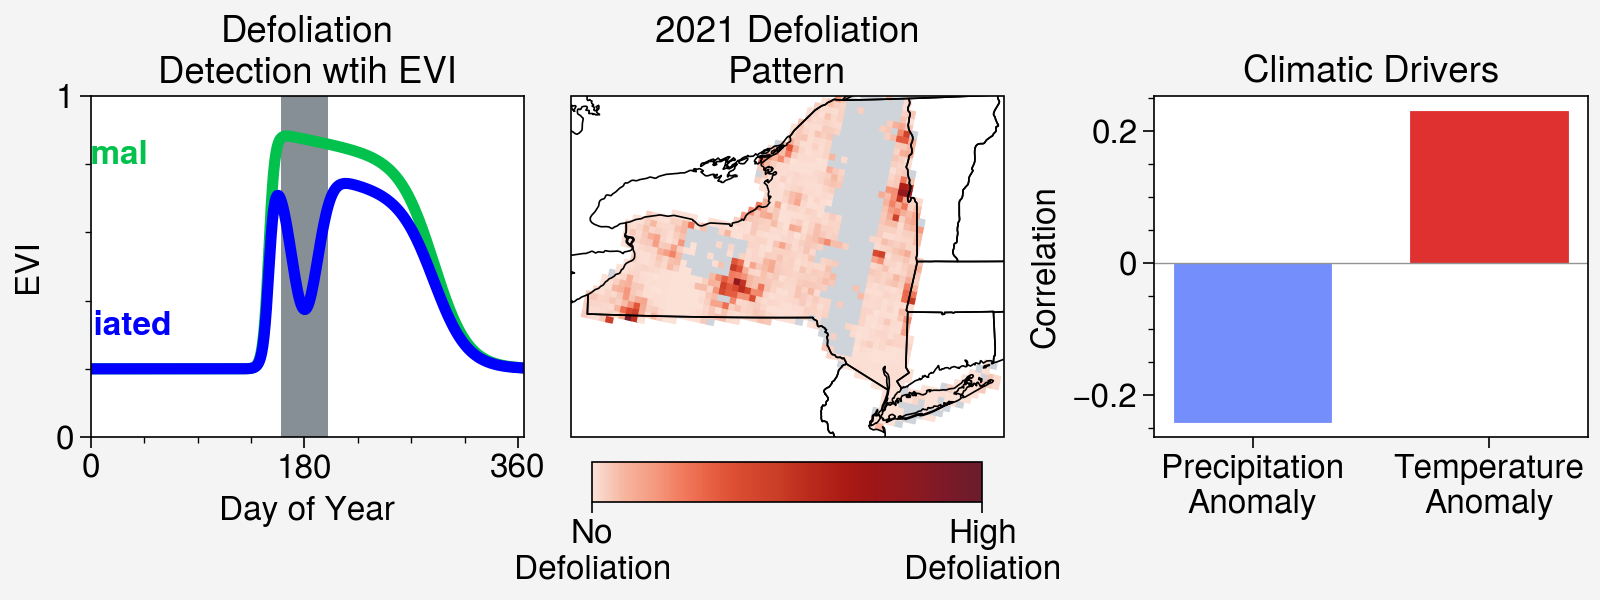

In [141]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

fig, axes = uplt.subplots(ncols=3, proj={2:dest_crs}, share=False, fontsize=12, figsize=(8, 3))

lw = 4
lw2 = 2
plot_defoliation_theory(axes[0], lw)
axes[0].format(grid=False, xlabel='Day of Year', title='Defoliation\nDetection wtih EVI')

plot_map(axes[1], fig)
axes[1].format(title='2021 Defoliation\nPattern')

plot_climate_effects(axes[2])
axes[2].format(grid=False, title='Climatic Drivers')

#fig.savefig('./Figures/GraphicalAbstract/graph_abstract.png', dpi=300)